In [1]:
import sys
sys.path.append('../')

In [2]:
from src.trainer import *
from main import *

import matplotlib.pyplot as plt
import seaborn as sns

import yaml

from argparse import Namespace

with open('../config.yaml', 'r') as f:
    config_dict = yaml.load(f, Loader=yaml.FullLoader)
args = Namespace(**config_dict)

In [3]:
print('Load Merge Data')
data = data_load(data_path='../' + args.data_path, use_wav=args.use_wav)
data['Emotion'] = data['Emotion'].apply(lambda x: x.replace('disqust', 'disgust'))
print('Complete Merge Dataset')

label_dict = {'neutral': 0, 'happy': 1, 'angry': 2, 'surprise': 3, 'sad': 4, 'fear': 5, 'disgust': 6}
subset_data = data.copy()
subset_data['Emotion'] = subset_data['Emotion'].map(label_dict)
subset_data = subset_data.dropna(subset=['Emotion'])

df_train, df_valid = train_test_split(
                                    subset_data,
                                    test_size=0.2,
                                    random_state=42,
                                    shuffle=True,
                                    stratify=subset_data['Emotion'],
                                    )

# set label transform
if args.label_transform:
    print('Apply Label transform')
    modify_data = data[data['Emotion'].apply(lambda x: (True if len(x.split(';'))==2 else False) & ('neutral' in  x.split(';')))]
    modify_data['Emotion'] = modify_data['Emotion'].apply(lambda x: x.replace('neutral', '').replace(';', ''))
    modify_data['Emotion'] = modify_data['Emotion'].map(label_dict)
    df_train = pd.concat([df_train, modify_data], axis=0)

df_train, df_valid = df_train.reset_index(drop=True), df_valid.reset_index(drop=True)

args.wav_config = AutoConfig.from_pretrained(args.wav_model, num_labels=len(label_dict), finetuning_task='wav2vec2_clf')
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(args.wav_model)
args.data_collator = DataCollatorCTCWithPadding(feature_extractor=feature_extractor, padding=True, max_length=args.audio_max_lens)

if 'xlm' in args.rnn_model:
    args.rnn_config = XLMRobertaConfig.from_pretrained(args.rnn_model)
    args.rnn_config.hidden_dropout_prob = 0
    args.rnn_config.attention_probs_dropout_prob = 0
    tokenizer = XLMRobertaTokenizer.from_pretrained(args.rnn_model)
else:
    args.rnn_config = AutoConfig.from_pretrained(args.rnn_model)
    args.rnn_config.hidden_dropout_prob = 0
    args.rnn_config.attention_probs_dropout_prob = 0
    tokenizer = AutoTokenizer.from_pretrained(args.rnn_model)

Load Merge Data


100%|██████████| 40/40 [01:55<00:00,  2.88s/it]


Complete Merge Dataset


In [4]:
args.valid_dataset = Custom_Dataset(args, df_valid, tokenizer, feature_extractor)

valid_dataloader = DataLoader(
                            args.valid_dataset,
                            batch_size=args.val_batch_size,
                            num_workers=1,
                            shuffle=False,
                            sampler = SequentialSampler(args.valid_dataset),
                            collate_fn=args.data_collator,
                            drop_last=True,
                            pin_memory=True,
                        )

args.use_concat = True
args.multimodal_method = 'rsa'
args.wav_config.pooling_mode = args.pooling_mode
args.rnn_config.num_classes = args.num_classes

model = MultiModel(args)
model.wav_freeze_feature_extractor()
model.to(args.device)

model.load_state_dict(torch.load('../models/f_rsa/EPOCH3_train_loss0.23938_valid_loss0.35843_train_f10.91496_valid_f10.89340.pth'))

Some weights of the model checkpoint at facebook/wav2vec2-large-960h-lv60-self were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60-self and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing 

<All keys matched successfully>

In [6]:
def valid_fn(args, valid_dataloader, model, criterion):
    
    model.eval()
    bar = tqdm(valid_dataloader)
    valid_preds = []
    valid_labels = []
    valid_loss = 0.0
    attn_weights = []

    with torch.no_grad():
        for idx, batch in enumerate(bar):
            batch = {k: v.to(args.device) for k, v in batch.items()}
            if args.use_amp:
                with torch.cuda.amp.autocast():
                    pred, attn_w = sharing_step(args, model, batch)
                    
                    loss = criterion(pred, batch['labels'])
            else:
                pred, attn_w = sharing_step(args, model, batch)
                
                loss = criterion(pred, batch['labels'])
            
            valid_preds += [pred.clone().detach().cpu()]
            valid_labels += [batch['labels'].clone().detach().cpu()]
            
            if args.multimodal_method=='rsa':
                attn_weights += [attn_w.clone().detach().cpu().numpy()]

            valid_loss += loss.item()
            bar.set_description('loss : %.5f' % (loss.item()))
        
        valid_loss /= idx

    valid_preds, valid_labels = np.concatenate(valid_preds), np.concatenate(valid_labels).reshape(-1)    
    valid_preds = np.argmax(valid_preds, 1)
    
    f1 = f1_score(valid_labels, valid_preds, average='weighted')
    valids = {  
                'valid_preds':valid_preds,
                'val_loss':valid_loss,
                'val_f1':f1,
                'attn_weights':attn_weights,
            }
    return valids

criterion = nn.CrossEntropyLoss()
valids = valid_fn(args, valid_dataloader, model, criterion)

loss : 0.17027: 100%|██████████| 80/80 [00:49<00:00,  1.61it/s]


In [7]:
attn_w = np.concatenate(valids['attn_weights'], axis=0)

In [8]:
labels = df_valid['Emotion'].values[:2560]
attn_w_0 = np.mean(attn_w[labels==0], axis=0)
attn_w_n0 = np.mean(attn_w[labels!=0], axis=0)

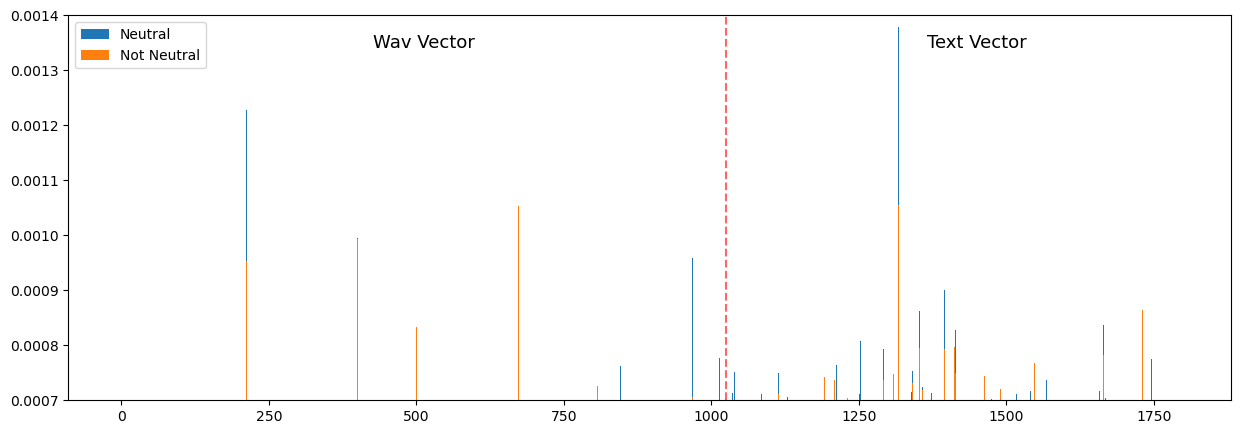

In [9]:
plt.figure(figsize=(15, 5))
plt.bar(np.arange(attn_w_0.shape[0]), np.median(attn_w_0, axis=0), width=0.55, alpha=1.0, label='Neutral')
plt.bar(np.arange(attn_w_n0.shape[0]), np.median(attn_w_n0, axis=0), width=0.55, alpha=1.0, label='Not Neutral')
plt.ylim(0.0007, 0.0014)
plt.axvline(1024, color='r', alpha=0.6, linestyle='--')
plt.text(512, 0.00135, "Wav Vector", fontsize=13, va='center', ha='center', alpha=1.0)
plt.text(1450, 0.00135, "Text Vector", fontsize=13, va='center', ha='center', alpha=1.0)
plt.legend(loc='upper left')
plt.show()